In [1]:
import os, json, sys, pickle, xmltodict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from llama_index.core import Settings
from llama_index.core.schema import TextNode
from llama_index.core.vector_stores.simple import SimpleVectorStoreData, SimpleVectorStore, VectorStoreQuery
from llama_index.core.vector_stores.types import MetadataFilters, FilterOperator
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.graph_stores.nebula import NebulaPropertyGraphStore
from pyhpo import Ontology
from typing import List
from nebulagraph_lite import nebulagraph_let as ng_let
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up

## Datasets

### Phenopackets

In [8]:
# load the phenopackets data
output_file = os.path.expanduser('~/scratch-llm/data/phenopackets/phenopacket_data.json') # from the Phenopackets dataset, including all symptoms recorded on each case report for each disease
with open(output_file, 'r') as f:
    phenopackets = json.load(f)

In [ ]:
# load results from DiseaseMode data from the phenopackets
results_file = os.path.expanduser('~/scratch-llm/results/disease_mode/disease_rag_results.json')
with open(results_file, 'r') as f:
    rag_results = json.load(f)

results_file = os.path.expanduser('~/scratch-llm/results/disease_mode/disease_no_rag_results.json')
with open(results_file, 'r') as f:
    no_rag_results = json.load(f)

In [2]:
# load phenopackets results
pp_results = pd.read_csv(os.path.expanduser('~/scratch-llm/results/disease_mode/pp_results.csv'))

### Orphanet very frequent 

In [6]:
# convert the XML file to a dictionary
file_path = os.path.expanduser('~/scratch-llm/data/Orphanet/Orphanet_HPO.xml') #diseases with HPO symptoms
with open(file_path, 'r', encoding='latin-1') as file:
    xml_content = file.read()
orpha_data = xmltodict.parse(xml_content)

In [9]:
# Obtain a list of very frequent symptoms from each disease in Orphanet
orpha_frequent = {}
for status in orpha_data['JDBOR']['HPODisorderSetStatusList']['HPODisorderSetStatus']:
    disorder = status['Disorder']
    name = disorder['Name']['#text']
    orpha_frequent[name] = []
    hpo_assoc_list = disorder.get('HPODisorderAssociationList', {}).get('HPODisorderAssociation', [])
    #print(f"Processing disorder: {name}")
    if isinstance(hpo_assoc_list, dict):
        hpo_assoc_list = [hpo_assoc_list]
    for assoc in hpo_assoc_list:
        freq = assoc.get('HPOFrequency', {}).get('Name', {}).get('#text', '')
        if freq == 'Very frequent (99-80%)': # very frequent includes "diagnostic criterion" and "pathognomonic" symptoms + some others
            hpo_name = assoc.get('HPO', {}).get('HPOTerm', '')
            orpha_frequent[name].append(hpo_name)
            # print(f"\t {hpo_name} ({freq})")

# extract the disease names in phenopackets that are also in orpha_frequent and keep the symptoms of orpha_frequent
phenopackets_orpha = {}
for disease, symptoms in phenopackets.items():
    if disease in orpha_frequent:
        phenopackets_orpha[disease] = orpha_frequent[disease]


In [3]:
# load Orphanet results
orpha_results = pd.read_csv(os.path.expanduser('~/scratch-llm/results/disease_mode/orpha_results.csv'))

## Embedidng model, graph and vector store

In [15]:
Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-mpnet-base-v2") # BAAI/bge-small-en-v1.5 /  m3 / sentence-transformers/all-mpnet-base-v2

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SimpleVectorStore:

In [16]:
with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_all-mpnet-base-v2.pkl'), 'rb') as f:
    all_nodes_embedded: List[TextNode] = pickle.load(f)
# Create dictionaries from the nodes
embedding_dict = {node.id_: node.get_embedding() for node in all_nodes_embedded}
text_id_to_ref_doc_id = {node.id_: node.ref_doc_id or "None" for node in all_nodes_embedded}
metadata_dict = {node.id_: node.metadata for node in all_nodes_embedded}

# Initialize the SimpleVectorStore with the dictionaries
vector_store = SimpleVectorStore(
    data = SimpleVectorStoreData(
        embedding_dict=embedding_dict,
        text_id_to_ref_doc_id=text_id_to_ref_doc_id,
        metadata_dict=metadata_dict,
    ),
    stores_text=True
)

GraphStore:

In [17]:
# !udocker pull vesoft/nebula-metad:v3
# !udocker create --name=nebula-metad vesoft/nebula-metad:v3
# !udocker setup --execmode=F1 nebula-metad
# !udocker pull vesoft/nebula-graphd:v3
# !udocker create --name=nebula-graphd vesoft/nebula-graphd:v3
# !udocker setup --execmode=F1 nebula-graphd
# !udocker pull vesoft/nebula-storaged:v3
# !udocker create --name=nebula-storaged vesoft/nebula-storaged:v3
# !udocker setup --execmode=F1 nebula-storaged

n = ng_let(in_container=True)
n.start() # Takes around 5 mins

Message: Activating storaged...
Result of `SHOW HOSTS`:
    errors:
        code: 0
    results:
        spaceName: 
        data:
            meta:
                None, None, None, None, None, None, None
            row:
                127.0.0.1, 9779, ONLINE, 101, PrimeKG:100, basketballplayer:1, PrimeKG:100, basketballplayer:1, 3.8.0
        columns:
            Host, Port, Status, Leader count, Leader distribution, Partition distribution, Version
        errors:
            code: 0
        latencyInUs: 1303
Info: loading basketballplayer dataset...

  _   _      _           _        ____                 _     
 | \ | | ___| |__  _   _| | __ _ / ___|_ __ __ _ _ __ | |__  
 |  \| |/ _ | '_ \| | | | |/ _` | |  _| '__/ _` | '_ \| '_ \ 
 | |\  |  __| |_) | |_| | | (_| | |_| | | | (_| | |_) | | | |
 |_| \_|\___|_.__/ \__,_|_|\__,_|\____|_|  \__,_| .__/|_| |_|
                                                |_|          
                                                lite version

[ OK

In [18]:
graph_store = NebulaPropertyGraphStore(
    space = "PrimeKG",
    username = "root",
    password = "nebula",
    url = "nebula://localhost:9669",
    props_schema= """`node_index` STRING, `node_type` STRING, `node_id` STRING, `node_name` STRING, 
        `node_source` STRING, `mondo_id` STRING, `mondo_name` STRING, `group_id_bert` STRING, 
        `group_name_bert` STRING, `orphanet_prevalence` STRING, `display_relation` STRING """,
)

# Evaluation

Map each symptom to the closest HPO term:<br>
(using the Vector and Graph store with the embedded nodes)

In [19]:
_ = Ontology()

In [20]:
def find_HPO_embedding(symptoms: List[str]) -> List[str]:
    phenotype_dict = {
        "key": "node_type",
        "value": "effect/phenotype",
        "operator": FilterOperator.EQ
    }
    phenotype_filter = MetadataFilters(filters=[phenotype_dict])
    new_symptoms = []
    for term in symptoms:
        term = term.strip()
        try: 
            if Ontology.get_hpo_object(term.capitalize()):
                new_symptoms.append(term.capitalize())

        except RuntimeError:
            query_embedding = Settings.embed_model.get_text_embedding(term)
            vector_results = vector_store.query(
                VectorStoreQuery(
                    query_embedding=query_embedding, 
                    similarity_top_k=1,
                    filters=phenotype_filter,
                )
            )
            if not vector_results.ids or len(vector_results.ids) == 0:
                print(f"Warning: No vector IDs found for term '{term}'")
                continue
            
            kg_node = graph_store.get(ids=[vector_results.ids[0]])
            if kg_node and len(kg_node) > 0:
                hpo_name = kg_node[0].properties['node_name'] if kg_node else None
                # print(f"Term: {term} | Vector ID: {vector_results.ids[0]} | KG node: {hpo_name} | Similarity: {vector_results.similarities[0]:.4f}")
                if vector_results.similarities[0] > 0.5 and kg_node:
                    new_symptoms.append(hpo_name)
            else:
                print(f"Term: {term} | No KG node found for vector ID: {vector_results.ids[0]}")
                continue
    return list(set(new_symptoms))

procesing of the diseases:

In [21]:
def DiseaseModeEvaluation(phenopackets, rag_results, no_rag_results):
    """
    Evaluate the Disease Mode results by comparing RAG and No-RAG results against phenopackets data.
    """
    results = []
    no_results = []
    for disease in tqdm(list(phenopackets.keys()), desc="Processing diseases"):
        # find the disease in the rag and no_rag results

        rag_result = rag_results.get(disease, None) 
        no_rag_result = no_rag_results.get(disease, None) 
        
        if rag_result is not None and no_rag_result is not None:
            # ensure HPO terms are used for symptoms
            rag_result['symptoms'] = find_HPO_embedding(rag_result['symptoms']) if rag_result['symptoms'] else []
            no_rag_result['symptoms'] = find_HPO_embedding(no_rag_result['symptoms']) if no_rag_result['symptoms'] else []

            common_symptoms = set(r.lower() for r in rag_result['symptoms']).intersection(set(n.lower() for n in no_rag_result['symptoms'])) if rag_result and no_rag_result else []
            rag_matches = set(s.lower() for s in rag_result['symptoms']).intersection(set(d.lower() for d in phenopackets[disease])) if rag_result else set()
            no_rag_matches = set(s.lower() for s in no_rag_result['symptoms']).intersection(set(d.lower() for d in phenopackets[disease])) if no_rag_result else set()

            
            count_rag = 0
            for symptom in rag_result['symptoms']:
                try: 
                    hpo_term = Ontology.get_hpo_object(symptom)
                except RuntimeError:
                    hpo_term = None
                if hpo_term:
                    if hpo_term.parents:
                        for parent in hpo_term.parents:
                            parent_name = parent.name

                            # check if parent_name is in the phenopackets data
                            if parent_name.lower() in [d.lower() for d in phenopackets[disease]]:
                                count_rag += 1
                    else:
                        continue
                else:
                    continue
            
            count_no_rag = 0
            for symptom in no_rag_result['symptoms']:
                try: 
                    hpo_term = Ontology.get_hpo_object(symptom)
                except RuntimeError:
                    hpo_term = None
                if hpo_term:
                    if hpo_term.parents:
                        for parent in hpo_term.parents:
                            parent_name = parent.name

                            # check if parent_name is in the phenopackets data
                            if parent_name.lower() in [d.lower() for d in phenopackets[disease]]:
                                count_no_rag += 1
                    else:
                        continue
                else:
                    continue

            #calculate precision and recall
            rag_precision = len(rag_matches) / len(rag_result['symptoms']) if len(rag_result['symptoms']) > 0 else 0.0
            rag_recall = len(rag_matches) / len(phenopackets[disease]) if len(phenopackets[disease]) > 0 else 0.0
            no_rag_precision = len(no_rag_matches) / len(no_rag_result['symptoms']) if len(no_rag_result['symptoms']) > 0 else 0.0
            no_rag_recall = len(no_rag_matches) / len(phenopackets[disease]) if len(phenopackets[disease]) > 0 else 0.0

            # calcuate the average symptom coverage
            symptom_coverage = len(set(phenopackets[disease]) - set(rag_result['symptoms']) - set(no_rag_result['symptoms'])) / len(set(phenopackets[disease])) if len(set(phenopackets[disease])) > 0 else 0.0

            # calculate the number of symptoms in RAG or no-RAG that ARE NOT

            results.append({
                "disease": disease.strip().replace("\"", ""),
                "common_symptoms": len(common_symptoms), # matches between rag and no_rag using HPO terms
                "total_symptoms": len(phenopackets[disease]), # total number of symptoms in the dataset
                "rag_total_symptoms": len(rag_result['symptoms']), # total number of symptoms in RAG result for a disease
                "rag_matches": len(rag_matches) + count_rag, # matches between rag and dataset using HPO terms
                "rag_hallucinations": len(rag_result['symptoms']) - len(rag_matches) - count_rag, # hallucinations in RAG results
                "no_rag_total_symptoms": len(no_rag_result['symptoms']), # total number of symptoms in No-RAG result for a disease
                "no_rag_matches": len(no_rag_matches) + count_no_rag, # matches between no_rag and dataset using HPO terms
                "no_rag_hallucinations": len(no_rag_result['symptoms']) - len(no_rag_matches) - count_no_rag, # hallucinations in No-RAG results
                "rag_accuracy": len(rag_matches) / len(phenopackets[disease]) if len(phenopackets[disease]) > 0 else 0.0,
                "no_rag_accuracy": len(no_rag_matches) / len(phenopackets[disease]) if len(phenopackets[disease]) > 0 else 0.0,
                "rag_precision": rag_precision,
                "rag_recall": rag_recall,
                "no_rag_precision": no_rag_precision,
                "no_rag_recall": no_rag_recall,
                "symptom_coverage": symptom_coverage, # fraction of unique symptoms that are predicted by neither RAG nor No-RAG
            })
        else:
            # print(f"{disease} was not found in rag or no_rag results")
            no_results.append(disease)
            continue
    return pd.DataFrame(results), no_results


## Phenopackets data

In [75]:
pp_results, pp_no_results = DiseaseModeEvaluation(phenopackets, rag_results, no_rag_results)

Processing diseases: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


## Orphanet (very frequent) data

In [23]:
orpha_results, orpha_no_results = DiseaseModeEvaluation(phenopackets_orpha, rag_results, no_rag_results)

Processing diseases: 100%|██████████| 52/52 [13:14<00:00, 15.27s/it]


# Data analysis

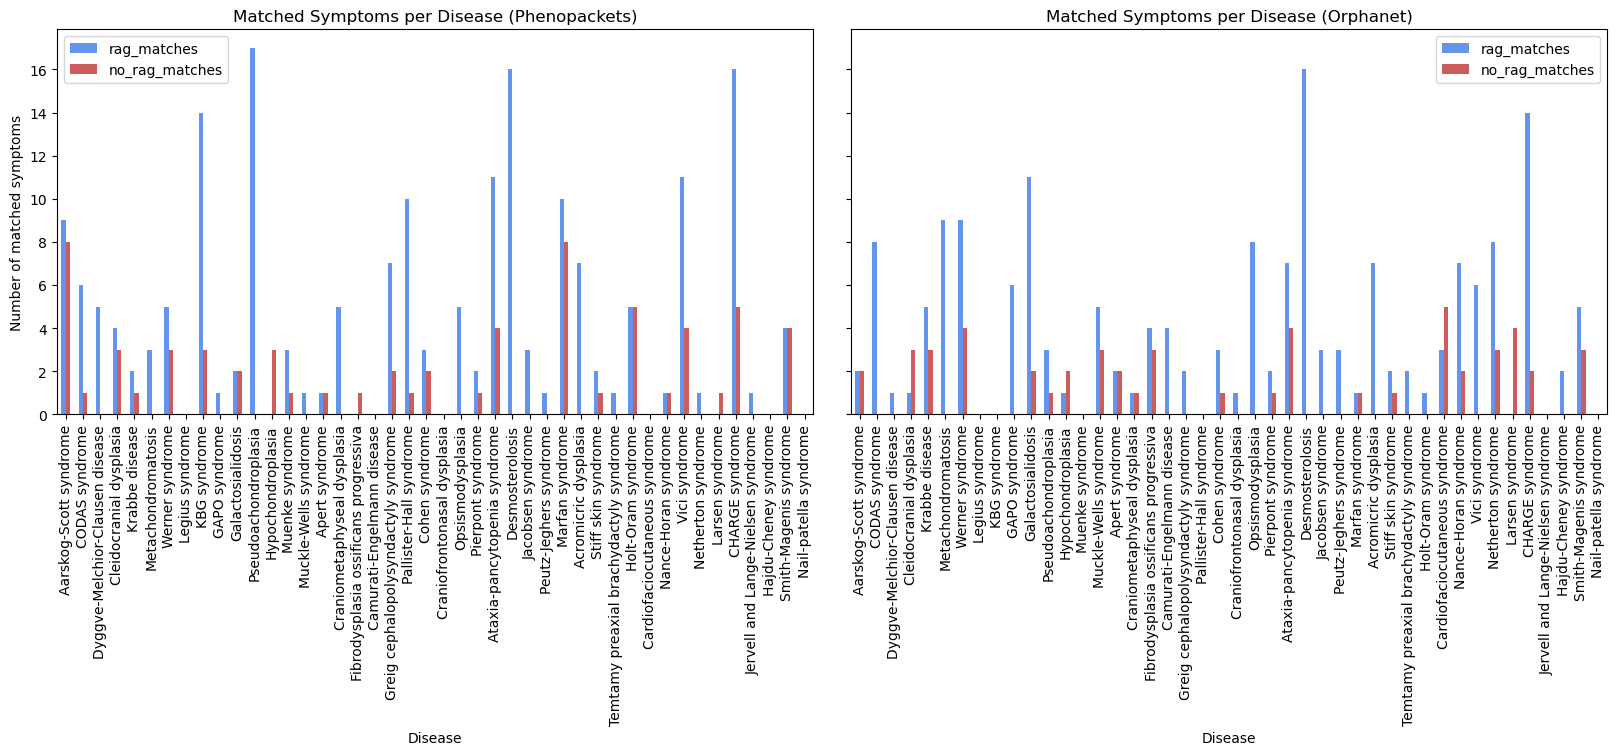

In [ ]:
# make a bar plot for each of the results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 40), sharey=True)
plt.subplots_adjust(wspace=0.05)

filtered_pp_results = pp_results[pp_results["disease"].isin(orpha_frequent.keys())]
filtered_pp_results.plot(
    ax=axes[0],
    x="disease",
    y=["rag_matches", "no_rag_matches"]#, "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred"],
    title="Matched Symptoms per Disease (Phenopackets)",
    ylabel="Number of matched symptoms",
    xlabel="Disease",
    figsize=(20, 5)
)

orpha_results.plot(
    ax=axes[1],
    x="disease",
    y=["rag_matches", "no_rag_matches"],# "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred"],
    title="Matched Symptoms per Disease (Orphanet)",
    ylabel="Number of matched symptoms",
    xlabel="Disease",
    figsize=(20, 5)
)
plt.show()


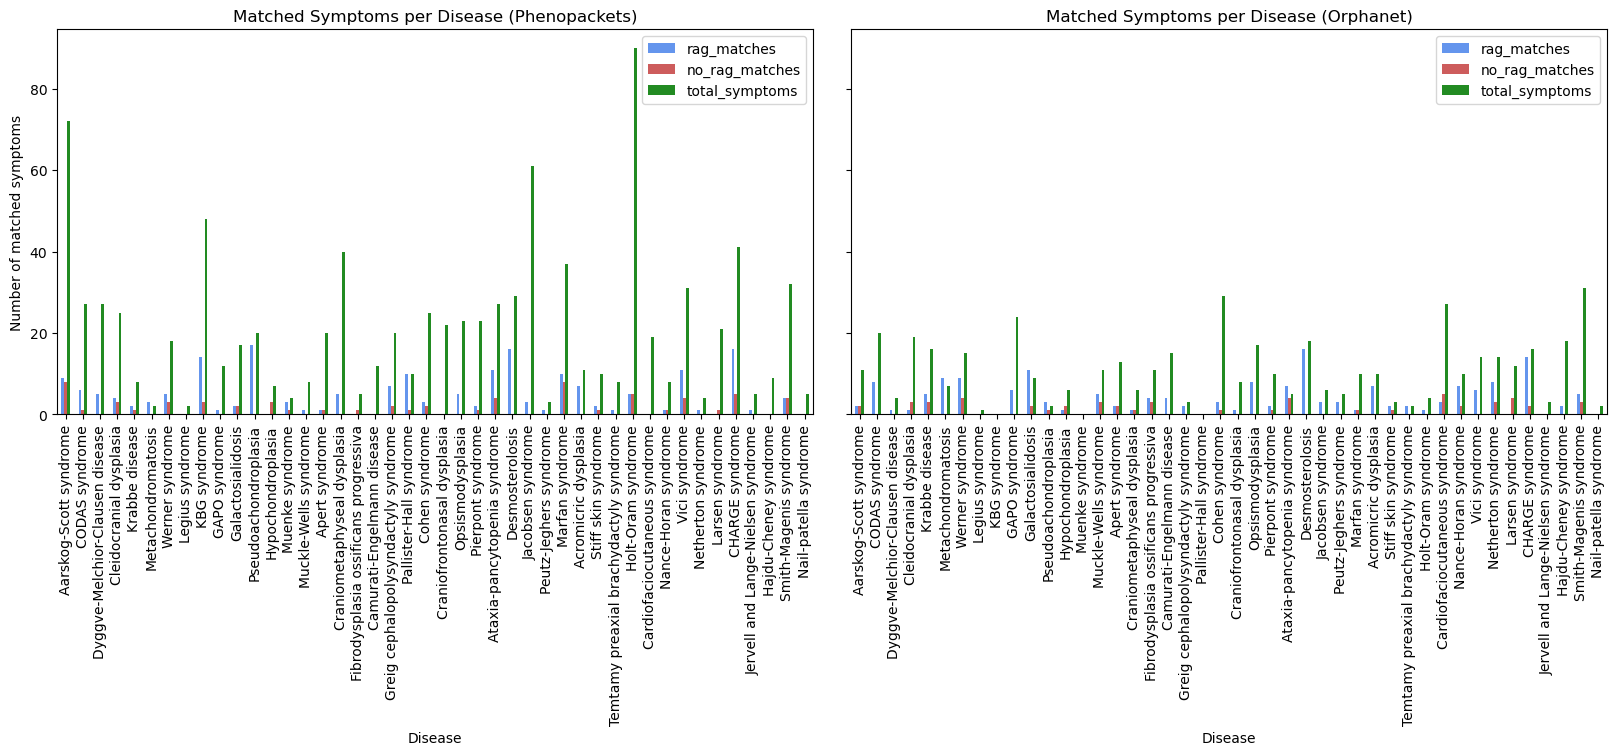

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 40), sharey=True)
plt.subplots_adjust(wspace=0.05)

filtered_pp_results = pp_results[pp_results["disease"].isin(orpha_frequent.keys())]
filtered_pp_results.plot(
    ax=axes[0],
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    title="Matched Symptoms per Disease (Phenopackets)",
    ylabel="Number of matched symptoms",
    xlabel="Disease",
    figsize=(20, 5)
)

orpha_results.plot(
    ax=axes[1],
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    title="Matched Symptoms per Disease (Orphanet)",
    ylabel="Number of matched symptoms",
    xlabel="Disease",
    figsize=(20, 5)
)
plt.show()

In [14]:
# get the absolute value of matches in relation to the total number of symptoms for the rag and no_rag results
rag_abs_matches = (pp_results["rag_matches"].abs() / pp_results["total_symptoms"]).mean()
no_rag_abs_matches = (pp_results["no_rag_matches"].abs() / pp_results["total_symptoms"]).mean()
print(f"Average RAG matches in relation to total symptoms: {rag_abs_matches:.4f}")
print(f"Average No-RAG matches in relation to total symptoms: {no_rag_abs_matches:.4f}")

Average RAG matches in relation to total symptoms: 0.2563
Average No-RAG matches in relation to total symptoms: 0.1362


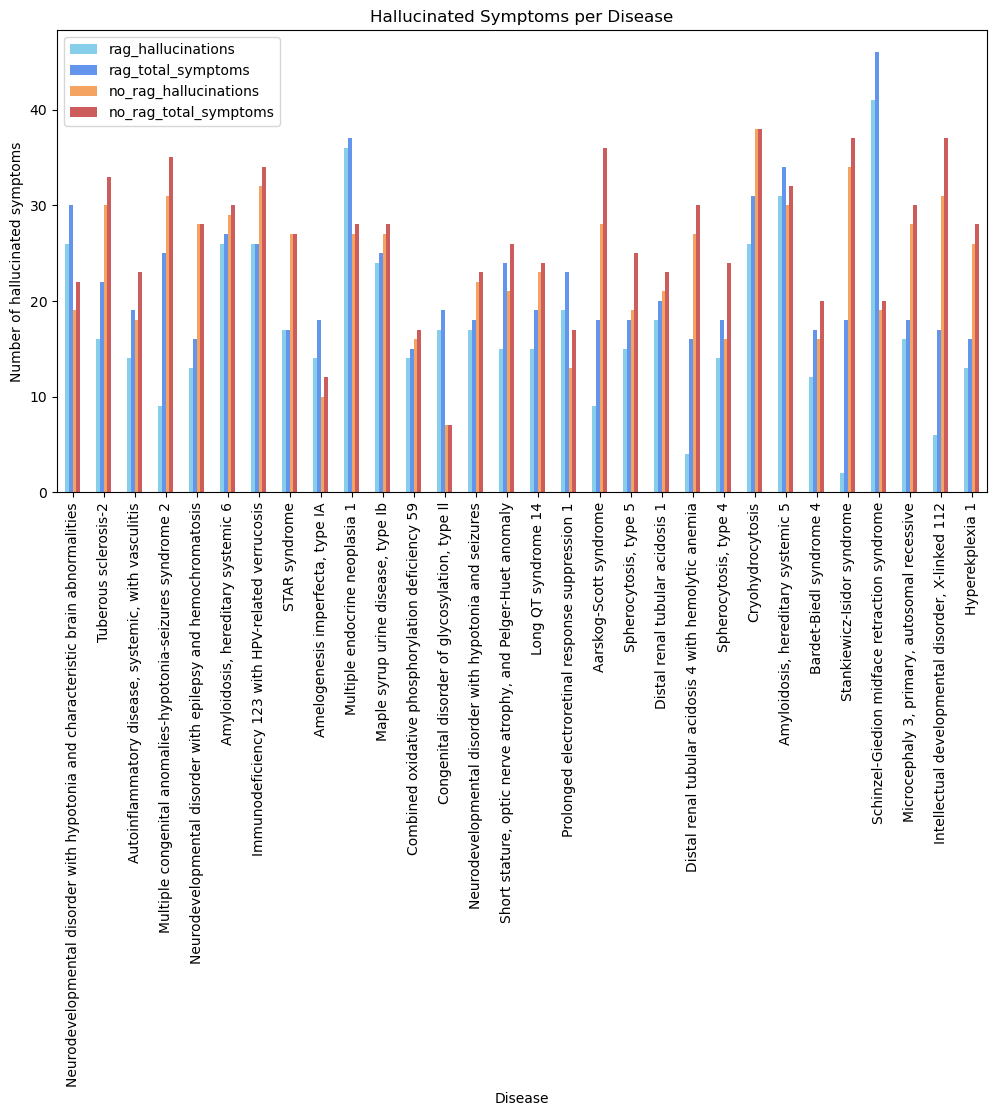

In [31]:
# plot the rag hallucinations and total_symptoms with different colors than no_rag results
pp_results[:30].plot(
    x="disease",
    y=["rag_hallucinations", "rag_total_symptoms", "no_rag_hallucinations", "no_rag_total_symptoms"],
    color=["skyblue", "cornflowerblue", "sandybrown", "indianred"],
    kind="bar",
    title="Hallucinated Symptoms per Disease",
    ylabel="Number of hallucinated symptoms",
    xlabel="Disease",
    figsize=(12, 6)
)
plt.show()

In [33]:
# count the percentage of diseases with more rag matches, no_rag matches, and equal matches from the results
rag_more_than_no_rag = (pp_results['rag_matches'] > pp_results['no_rag_matches']).sum() / len(pp_results) * 100
no_rag_more_than_rag = (pp_results['no_rag_matches'] > pp_results['rag_matches']).sum() / len(pp_results) * 100
equal_matches = (pp_results['rag_matches'] == pp_results['no_rag_matches']).sum() / len(pp_results) * 100

# calculate the same for orpha_results
rag_more_than_no_rag_orpha = (orpha_results['rag_matches'] > orpha_results['no_rag_matches']).sum() / len(orpha_results) * 100
no_rag_more_than_rag_orpha = (orpha_results['no_rag_matches'] > orpha_results['rag_matches']).sum() / len(orpha_results) * 100
equal_matches_orpha = (orpha_results['rag_matches'] == orpha_results['no_rag_matches']).sum() / len(orpha_results) * 100

# make a table with the results
results_table = pd.DataFrame({
    "Metric": ["RAG > No-RAG", "No-RAG > RAG ", "Equal matches"],
    "Phenopackets": [rag_more_than_no_rag, no_rag_more_than_rag, equal_matches],
    "Orphanet (very frequent)": [rag_more_than_no_rag_orpha, no_rag_more_than_rag_orpha, equal_matches_orpha]
})
print(results_table)


          Metric  Phenopackets  Orphanet (very frequent)
0   RAG > No-RAG     56.696429                 68.181818
1  No-RAG > RAG      20.758929                  9.090909
2  Equal matches     22.544643                 22.727273


Text(0.5, 1.0, 'F1 Score Distribution with the Phenopackets dataset')

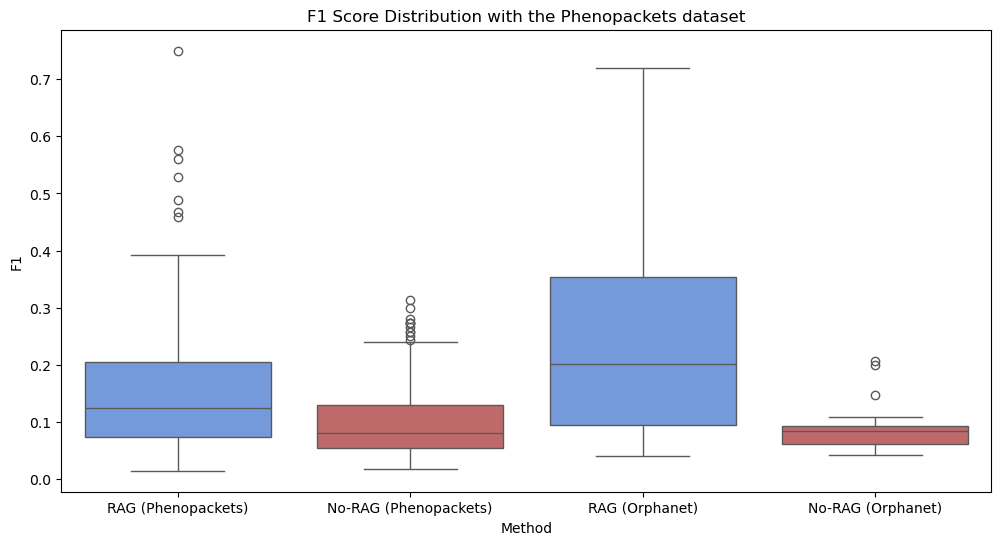

In [35]:
import seaborn as sns

pp_rag_f1 = pp_results['rag_precision'] * pp_results['rag_recall'] / (pp_results['rag_precision'] + pp_results['rag_recall']).replace(0, np.nan) * 2
pp_nonrag_f1 = pp_results['no_rag_precision'] * pp_results['no_rag_recall'] / (pp_results['no_rag_precision'] + pp_results['no_rag_recall']).replace(0, np.nan) * 2

orpha_rag_f1 = orpha_results['rag_precision'] * orpha_results['rag_recall'] / (orpha_results['rag_precision'] + orpha_results['rag_recall']).replace(0, np.nan) * 2
orpha_nonrag_f1 = orpha_results['no_rag_precision'] * orpha_results['no_rag_recall'] / (orpha_results['no_rag_precision'] + orpha_results['no_rag_recall']).replace(0, np.nan) * 2

# create a DataFrame for F1 scores
f1_df = pd.DataFrame({
	'F1': pd.concat([pp_rag_f1, pp_nonrag_f1, orpha_rag_f1, orpha_nonrag_f1], ignore_index=True),
	'Method': ['RAG (Phenopackets)'] * len(pp_rag_f1) + ['No-RAG (Phenopackets)'] * len(pp_nonrag_f1) +
			  ['RAG (Orphanet)'] * len(orpha_rag_f1) + ['No-RAG (Orphanet)'] * len(orpha_nonrag_f1)
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='F1', hue='Method', data=f1_df, legend=False,
            palette={'RAG (Phenopackets)': 'cornflowerblue', 'No-RAG (Phenopackets)': 'indianred',
                     'RAG (Orphanet)': 'cornflowerblue', 'No-RAG (Orphanet)': 'indianred'})
plt.title("F1 Score Distribution with the Phenopackets dataset")

In [36]:
# make a table with precision, recall, and F1 scores for both pp_results and orpha_results
precision_recall_f1 = pd.DataFrame({
    "Method": ["RAG (Phenopackets)", "No-RAG (Phenopackets)", "RAG (Orphanet)", "No-RAG (Orphanet)"],   
    "Precision": [pp_results['rag_precision'].mean(), pp_results['no_rag_precision'].mean(),
                  orpha_results['rag_precision'].mean(), orpha_results['no_rag_precision'].mean()],
    "Recall": [pp_results['rag_recall'].mean(), pp_results['no_rag_recall'].mean(),
               orpha_results['rag_recall'].mean(), orpha_results['no_rag_recall'].mean()],
    "F1": [pp_rag_f1.mean(), pp_nonrag_f1.mean(),
           orpha_rag_f1.mean(), orpha_nonrag_f1.mean()]
})
print(precision_recall_f1)


                  Method  Precision    Recall        F1
0     RAG (Phenopackets)   0.145789  0.166912  0.151561
1  No-RAG (Phenopackets)   0.071948  0.100821  0.097274
2         RAG (Orphanet)   0.148172  0.343484  0.226255
3      No-RAG (Orphanet)   0.029601  0.074453  0.089755


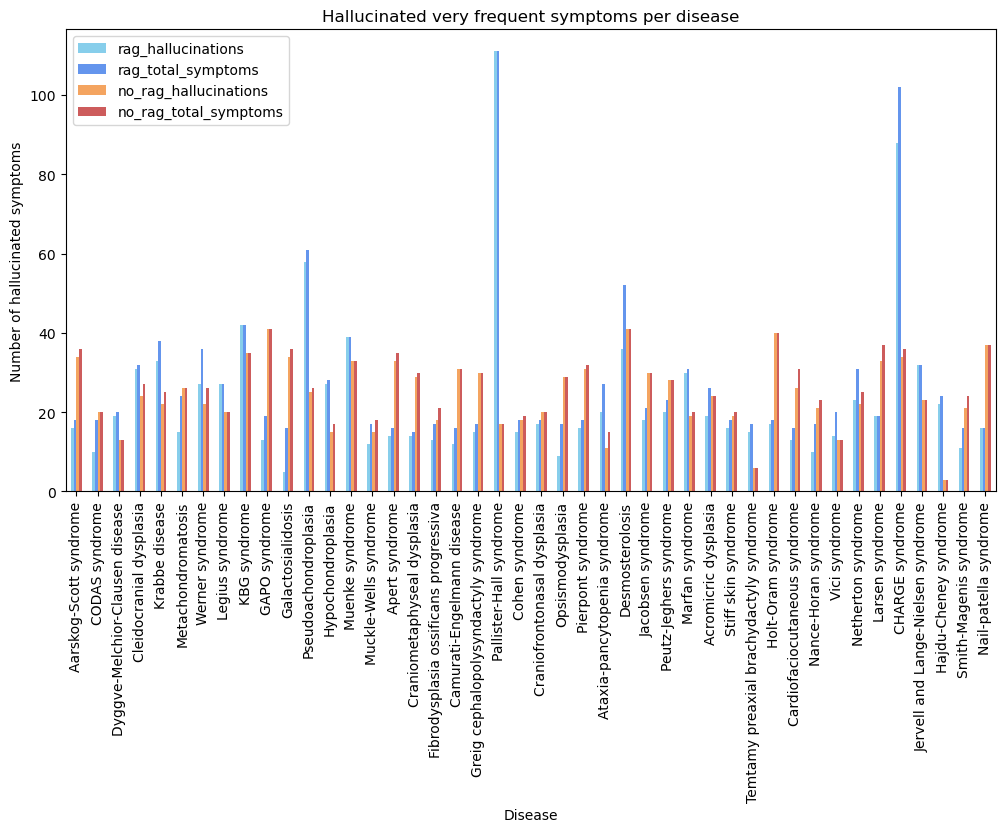

In [37]:
orpha_results.plot(
    x="disease",
    y=["rag_hallucinations", "rag_total_symptoms", "no_rag_hallucinations", "no_rag_total_symptoms"],
    color=["skyblue", "cornflowerblue", "sandybrown", "indianred"],
    kind="bar",
    title="Hallucinated very frequent symptoms per disease",
    ylabel="Number of hallucinated symptoms",
    xlabel="Disease",
    figsize=(12, 6)
)
plt.show()

In [ ]:
# count for how many diseases in orpha_results no_rag_hallucinations is greater than rag_hallucinations
orpha_hallucinations = (orpha_results['no_rag_hallucinations'] > orpha_results['rag_hallucinations']).sum()
orpha_hallucinations_percentage = orpha_hallucinations / len(orpha_results) * 100
print(f"Orphanet diseases with more no-RAG hallucinations than RAG: {orpha_hallucinations} ({orpha_hallucinations_percentage:.2f}%)")

# same for phenopackets
pp_hallucinations = (pp_results['no_rag_hallucinations'] > pp_results['rag_hallucinations']).sum()
pp_hallucinations_percentage = pp_hallucinations / len(pp_results) * 100
print(f"Phenopackets diseases with more no-RAG hallucinations than RAG: {pp_hallucinations} ({pp_hallucinations_percentage:.2f}%)")


Orphanet diseases with more no-RAG hallucinations than RAG: 26 (59.09%)
Phenopackets diseases with more no-RAG hallucinations than RAG: 310 (69.20%)


In [ ]:
n.stop() # Stop the Nebula Graph service